In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
pd.options.display.float_format = '{:.6f}'.format  

# 그래프에서 한글 깨짐 방지
import platform
if platform.system() == "Darwin":          # MAC인 경우
    plt.rc('font', family ="AppleGothic")
else:
    plt.rc('font',family='Malgun Gothic')

#멧플로립에서 음수를 표시
plt.rc('axes',unicode_minus=False)

#워닝 메시지
import warnings
warnings.filterwarnings('ignore')

In [16]:
df_origin = pd.read_csv('./datasets/원본data.csv',index_col=0)
df=pd.read_csv('./datasets/원본data.csv',index_col=0)


## VAR모델처럼 전처리

In [17]:
## 경제심리지수, 기계류내수출,수출입물가비율 ,장단기금리차, 외환보유액, 뉴스심리지수, 원달러,G20, 천연가스--> 정상적이다

## G7. G20은 비슷하므로 G7 drop
#df2=df2.drop('G7',axis=1)

df['재고순환지표']+=25
df['재고순환지표']=np.log1p(df['재고순환지표']/df['재고순환지표'].shift(1))
df['건설수주액']=np.log1p(df['건설수주액']/df['건설수주액'].shift(1))
df['코스피']=np.log1p(df['코스피']/df['코스피'].shift(1))
df['원엔']=np.log1p(df['원엔']/df['원엔'].shift(1))
df['원위안']=np.log1p(df['원위안']/df['원위안'].shift(1))
df['CD']=np.log1p(df['CD']/df['CD'].shift(1))
df['유가']=np.log1p(df['유가']/df['유가'].shift(1))
df['미장단기']+=0.9
df['미장단기']=np.log1p(df['미장단기']/df['미장단기'].shift(1))
df['거래량']=np.log1p(df['거래량']/df['거래량'].shift(1))
df['구리']=np.log1p(df['구리']/df['구리'].shift(1))
df['은']=np.log1p(df['은']/df['은'].shift(1))
df['금']=np.log1p(df['금']/df['금'].shift(1))

df['원달러'] /=1000
df['경제심리지수'] /=100
df['기계류내수출'] /=100
df['수출입물가비율'] /=100
df['뉴스심리지수'] /=100
df['G20']/=100

df['천연가스']/=10

df['종가']=np.log(df['종가']/df['종가'].shift(1))
df=df.dropna(axis=0)


## ACF,PACF --> lag찾기 (주관)

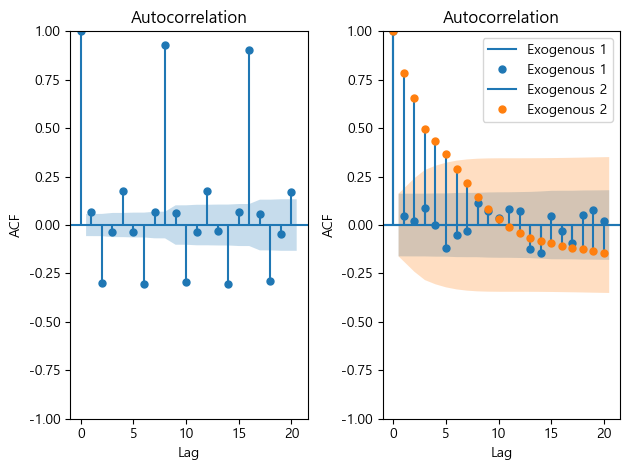

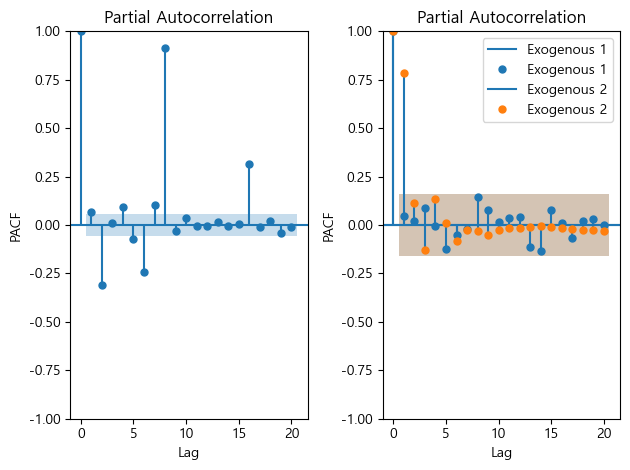

In [18]:
from statsmodels.tsa.statespace.varmax import VARMAX
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# 그래프에서 한글 깨짐 방지
import matplotlib.pyplot as plt

# plt.rc('font', family='NanumBarunGothic')
data =df.iloc[:147][['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','종가']].values.flatten()
exog= df.iloc[:147][['원엔','G20']].values

# 내생 변수와 외생 변수를 함께 고려하여 ACF와 PACF를 그리는 함수 정의
def plot_acf_pacf(data, exog, lags):
    # 내생 변수의 ACF 그래프
    plt.subplot(121)
    plot_acf(data, lags=lags, ax=plt.gca())
    plt.xlabel('Lag')
    plt.ylabel('ACF')

    # 외생 변수의 ACF 그래프
    plt.subplot(122)
    for i in range(exog.shape[1]):
        plot_acf(exog[:, i], lags=lags, ax=plt.gca(), label=f'Exogenous {i+1}')
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 내생 변수의 PACF 그래프
    plt.subplot(121)
    plot_pacf(data, lags=lags, ax=plt.gca())
    plt.xlabel('Lag')
    plt.ylabel('PACF')

    # 외생 변수의 PACF 그래프
    plt.subplot(122)
    for i in range(exog.shape[1]):
        plot_pacf(exog[:, i], lags=lags, ax=plt.gca(), label=f'Exogenous {i+1}')
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    plt.legend()

    plt.tight_layout()
    plt.show()


# ACF와 PACF를 그리기
max_lag = 20  # 최대 시차(lag)
plot_acf_pacf(data, exog, lags=max_lag)

In [19]:
# train 데이터 프레임 정의
train_data = df.iloc[:147][['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','종가']]
train_exog = df.iloc[:147][['원엔','G20']]
train = pd.DataFrame(train_data)
train_exog = pd.DataFrame(train_exog)

# test 데이터 프레임 정의
test_data = df.iloc[147:][['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','종가']]
test_exog = df.iloc[147:][['원엔','G20']]
test = pd.DataFrame(test_data)
test_exog = pd.DataFrame(test_exog)

## 모델 학습

In [20]:
# from statsmodels.tsa.statespace.varmax import VARMAX
# import numpy as np
# import joblib

# # 관련 데이터 프레임을 NumPy 배열로 변환
# train_data = df.iloc[:147][['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','종가']].values
# train_exog = df.iloc[:147][['원엔','G20']].values
# test_data = df.iloc[147:][['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','종가']].values
# test_exog = df.iloc[147:][['원엔','G20']].values

# # 예측값을 저장할 빈 리스트 초기화
# pred = []

# # VARMAX 모델 초기화 및 학습
# model_varmax = VARMAX(endog=train_data, exog=train_exog, order=(6, 2))
# model_fit = model_varmax.fit(disp=False)
# for t in range(len(test_data)):
#     # 한 단계 예측
#     forecast = model_fit.forecast(steps=1, exog=[train_exog[-2]])
#     joblib.dump(model_fit, 'varmax_update.pkl')
#     # 예측값을 리스트에 추가
#     pred.append(forecast[0])

#     # 새로운 데이터로 VARMAX 모델 재학습
#     train_data = np.concatenate([train_data, [test_data[t]]])
#     train_exog = np.concatenate([train_exog, [test_exog[t]]])
#     model_varmax = VARMAX(endog=train_data, exog=train_exog, order=(6, 2))
#     model_varmax.initialize_approximate_diffuse()
#     model_fit = model_varmax.fit(disp=False)

#     print(f'{t+1}번째')



In [21]:
df_varmax=pd.read_csv('./datasets/varmax_final_update.csv',index_col=0)
df_varmax.iloc[20]=[0.925058674,110.2271412,88.60595327,0.696405183,1.055167848,1104.011643,0.662007531,0.045289569]

## 평가지표

In [22]:
show=pd.read_csv('./datasets/VARMAX최종결과2.csv',index_col=0)

In [23]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Calculate mean absolute error
mae = mean_absolute_error(show['실제종가'],show['예측종가'])
print('MAE: %f' % mae)

#Calculate mean squared error and root mean squared error
mse = mean_squared_error(show['실제종가'], show['예측종가'])
print('MSE: %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

#Calculate mean_absolute_percentage_error
mape = mean_absolute_percentage_error(show['실제종가'],show['예측종가'])
print('MAPE: %f' % mape)

MAE: 88.384823
MSE: 11749.550388
RMSE: 108.395343
MAPE: 0.057182


## 시각화

In [24]:
df_origin_gr=df_origin.iloc[:149][['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','G20','종가']]

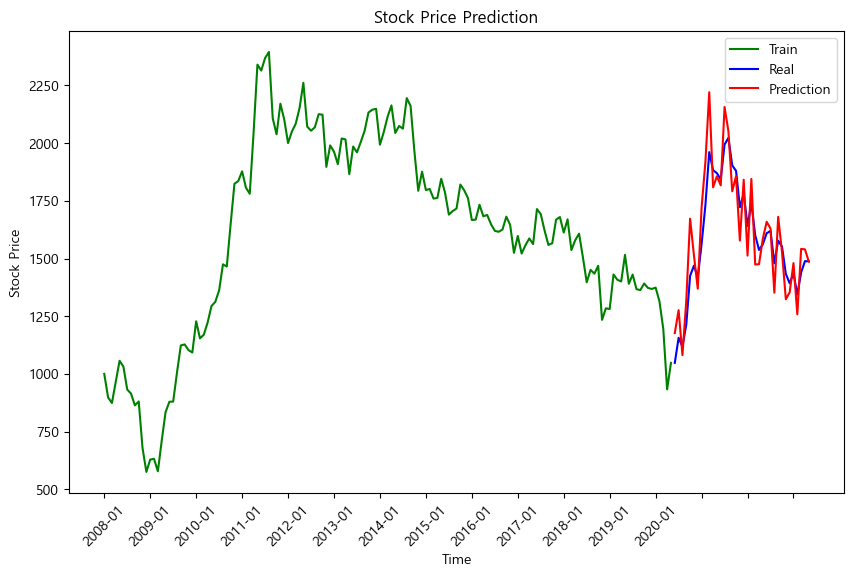

In [25]:
plt.figure(figsize=(10,6))
# Add the training set to the plot:
plt.plot(df_origin_gr['종가'], color='green', label='Train')
# Plot the test and prediction data:
plt.plot(range(len(df_origin_gr['종가']), len(df_origin_gr['종가'])+len(show['실제종가'])), show['실제종가'], color='blue', label='Real')
plt.plot(range(len(df_origin_gr['종가']), len(df_origin_gr['종가'])+len(show['실제종가'])), show['예측종가'], color='red', label='Prediction')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(range(0, len(df_origin_gr['종가'])+len(show['실제종가']), 12), rotation=45)
plt.legend()
plt.show()

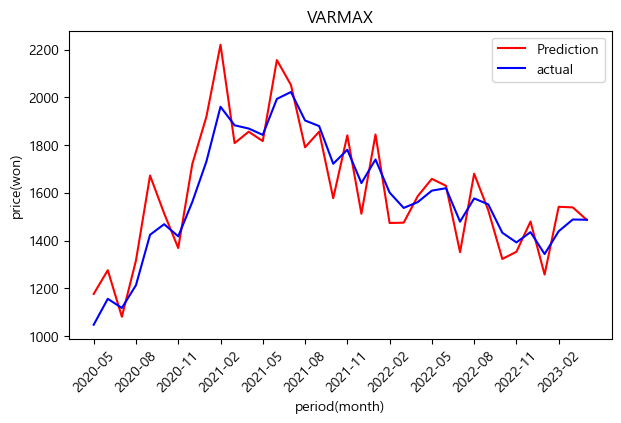

In [39]:
plt.figure(figsize=(7,4))
plt.title('VARMAX')
plt.ylabel('price(won)')
plt.xlabel('period(month)')
plt.plot(show['예측종가'], label='Prediction', color='r')
plt.plot(show['실제종가'], label='actual', color='b')
plt.legend(loc='best')
plt.xticks(range(0, len(show), 3), rotation=45)  # 인덱스를 6개마다 표시
plt.show()


In [26]:
# import pickle
# from statsmodels.tsa.statespace.varmax import VARMAXResults
# with open('varmax.pkl', 'rb') as file:
#     model = pickle.load(file)
# model = VARMAXResults.load(model)

In [29]:
import joblib 
model = joblib.load("varmax.pkl")

In [30]:
model.resid

array([[ 6.74643709e-01,  1.12000000e+02,  1.03700000e+02, ...,
         9.44100000e+02,  6.60071929e-01, -1.07618619e-01],
       [-1.26314396e+01,  1.99748663e+01, -1.85468568e+01, ...,
        -9.46101570e+02,  4.84038558e-01, -2.79018183e+00],
       [ 3.75343460e+00, -2.20023693e+01, -2.79098122e+00, ...,
         3.02160789e+02, -3.87668325e-01, -8.68441353e-01],
       ...,
       [-3.43044690e-01, -1.01075376e+00,  2.12863343e+00, ...,
        -1.93555686e+00, -3.97726569e-03, -5.79497455e-02],
       [-1.87599284e-01,  9.64693420e-01,  2.90477674e-01, ...,
        -4.01035934e+01, -2.80557900e-02,  2.32190994e-02],
       [-1.01466027e-01, -5.25377368e-01,  1.37450304e+00, ...,
         7.60576586e+01,  1.83336519e-02,  2.81208075e-02]])

## 잔차 검정

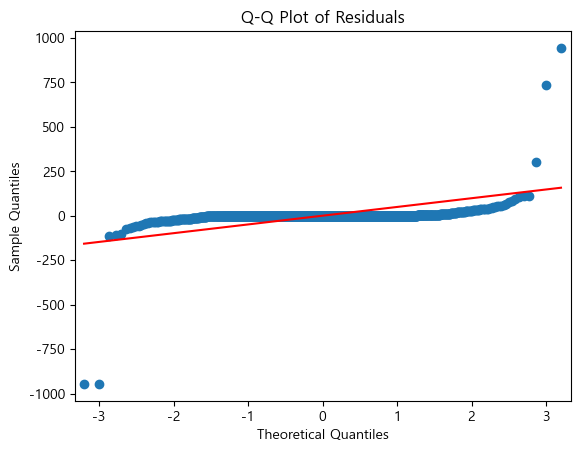

Normality test statistic: 1262.6348173552108
p-value: 6.642523229562809e-275


In [31]:
from scipy.stats import normaltest
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Residuals
residuals = model.resid


# Residual analysis


# Q-Q Plot
sm.qqplot(residuals.flatten(), line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# 잔차의 정규성 검정
statistic, p_value = normaltest(residuals.flatten())

print("Normality test statistic:", statistic)
print("p-value:", p_value)


In [32]:
# from scipy.stats import jarque_bera
import numpy as np
from scipy.stats import jarque_bera


# Jarque-Bera 정규성 검정 수행
jb_value, p_value = jarque_bera(residuals)

# 검정 통계량과 p-value 출력 (소수점 6번째 자리까지)
print("Jarque-Bera 검정 통계량: {:.6f}".format(jb_value))
print("p-value: {:.6f}".format(p_value))


Jarque-Bera 검정 통계량: 5962953.721429
p-value: 0.000000


In [33]:
residuals = pd.DataFrame(residuals,columns=train_data.columns).reset_index(drop=True)

In [34]:
residuals.corr()

,재고순환지표,경제심리지수,수출입물가비율,코스피,장단기,원달러,CD,종가
재고순환지표,1.000000,0.052388,0.106252,0.373841,0.861020,0.499416,-0.356484,0.662235
경제심리지수,0.052388,1.000000,0.543918,0.635366,-0.231669,0.077215,0.177499,0.139780
수출입물가비율,0.106252,0.543918,1.000000,0.773064,0.054083,0.386739,0.165835,0.222887
코스피,0.373841,0.635366,0.773064,1.000000,0.302345,0.634205,0.326500,0.427094
장단기,0.861020,-0.231669,0.054083,0.302345,1.000000,0.725572,-0.076118,0.364424
원달러,0.499416,0.077215,0.386739,0.634205,0.725572,1.000000,0.507742,0.054470
CD,-0.356484,0.177499,0.165835,0.326500,-0.076118,0.507742,1.000000,-0.555278
종가,0.662235,0.139780,0.222887,0.427094,0.364424,0.054470,-0.555278,1.000000


In [35]:
from statsmodels.stats.stattools import durbin_watson

durbin_res1 = pd.DataFrame([residuals.columns, 
                           [round(x,2) for x in durbin_watson(residuals)]]).T
durbin_res1.set_index([0],inplace=True)
durbin_res1.index.name = 'Variable'
durbin_res1.columns=['Durbin-Watson (lag 1)']
durbin_res1


,Durbin-Watson (lag 1)
Variable,
재고순환지표,2.760000
경제심리지수,1.370000
수출입물가비율,1.540000
코스피,1.640000
장단기,2.850000
원달러,2.590000
CD,1.290000
종가,1.680000


In [36]:
def cal_dw_stat(res, lag):
    n = len(res)
    a = np.zeros(n)
    a[0] = -1
    a[lag] = 1
    a = np.expand_dims(a, axis=1)
    for i in range(n-lag-1):
        temp = np.zeros(n)
        temp[i+1] = -1
        temp[i+1+lag] = 1
        temp = np.expand_dims(temp, axis=1)
        a = np.concatenate([a, temp], axis=1)

    H = a.dot(a.T)
    dw_stat = res.dot(H.dot(res)) / np.sum(np.square(res - np.mean(res)))
    return dw_stat

dw_values = []
for col in residuals.columns:
    dw_value = cal_dw_stat(residuals[col].values.flatten(), lag=2)
    dw_values.append(dw_value)

durbin_res = pd.DataFrame({'Durbin-Watson (lag 2)': dw_values}, index=residuals.columns)
durbin_res.index.name = 'Variable'
durbin_res


,Durbin-Watson (lag 2)
Variable,
재고순환지표,0.783899
경제심리지수,1.555030
수출입물가비율,1.280891
코스피,1.218993
장단기,0.828961
원달러,1.179139
CD,2.705761
종가,1.997677


In [37]:
pred = pd.Series(show['예측종가'].values.flatten()).pct_change()
test = pd.Series(show['실제종가'].values.flatten()).pct_change()

In [38]:
re = 1
for i in range(len(pred)):
  if pred[i] > 0:
    re *= (1+test[i])

re

2.5986729480166972